Import all necessary libraries

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)
# 2.13.0

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import os
import glob
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

from object_detection.utils import visualization_utils as viz_utils

2024-01-16 22:54:33.602543: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-16 22:54:35.376833: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.0


Here I want to use different networks and compare the results.
All these networks were trained on different dataSets, so I need to prepare labels for each of them.

In [2]:
# ImageNetLabels

# labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
# imagenet_labels = np.array(open(labels_path).read().splitlines())
# print(imagenet_labels)

In [3]:
# COCOLabels

# List of the strings that is used to add correct label for each box
coco_labels = {}
PATH_TO_LABELS = 'coco_labels.txt'
labels = np.array(open(PATH_TO_LABELS).read().splitlines())
for row in labels:
    label = row.split(': ')
    coco_labels[int(label[0])] = {'name':label[1]}
print(coco_labels)

{1: {'name': 'person'}, 2: {'name': 'bicycle'}, 3: {'name': 'car'}, 4: {'name': 'motorcycle'}, 5: {'name': 'airplane'}, 6: {'name': 'bus'}, 7: {'name': 'train'}, 8: {'name': 'truck'}, 9: {'name': 'boat'}, 10: {'name': 'traffic light'}, 11: {'name': 'fire hydrant'}, 13: {'name': 'stop sign'}, 14: {'name': 'parking meter'}, 15: {'name': 'bench'}, 16: {'name': 'bird'}, 17: {'name': 'cat'}, 18: {'name': 'dog'}, 19: {'name': 'horse'}, 20: {'name': 'sheep'}, 21: {'name': 'cow'}, 22: {'name': 'elephant'}, 23: {'name': 'bear'}, 24: {'name': 'zebra'}, 25: {'name': 'giraffe'}, 27: {'name': 'backpack'}, 28: {'name': 'umbrella'}, 31: {'name': 'handbag'}, 32: {'name': 'tie'}, 33: {'name': 'suitcase'}, 34: {'name': 'frisbee'}, 35: {'name': 'skis'}, 36: {'name': 'snowboard'}, 37: {'name': 'sports ball'}, 38: {'name': 'kite'}, 39: {'name': 'baseball bat'}, 40: {'name': 'baseball glove'}, 41: {'name': 'skateboard'}, 42: {'name': 'surfboard'}, 43: {'name': 'tennis racket'}, 44: {'name': 'bottle'}, 46: {

For easier access to different neural networks I created a dictionary with all necessary details of each used network.
Here is some metrics:

| Model | Metric | Value |
|:--------:|:--------:|:--------:|
| mobilenet-v2 | mAP on COCO 2017 test set | 22.2 |
| efficientdet | mAP on COCO 2017 test set | 33.6 |

In [21]:
nn_models = {
    'mobilenet': {
        'size': 320,
        'url': "https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1",
        'labels': coco_labels
    },
    'efficientdet': {
        'size': 512,
        'url': "https://www.kaggle.com/models/tensorflow/efficientdet/frameworks/TensorFlow2/variations/d0/versions/1",
        'labels': coco_labels
    }
}

Set current neural network model and load detector from Hub.

In [5]:
CURRENT_MODEL = 'mobilenet'
SIZE = nn_models[CURRENT_MODEL]['size']
URL = nn_models[CURRENT_MODEL]['url']
LABELS = nn_models[CURRENT_MODEL]['labels']

# no need to make it a keras layer
detector = hub.load(URL)

# or with KerasLayer, result is the same
# m = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/ssd-mobilenet-v2/frameworks/TensorFlow2/variations/ssd-mobilenet-v2/versions/1",
#                    signature = 'serving_default',
#                    signature_outputs_as_dict=True)

2024-01-16 12:54:28.582310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.834706: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.834857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.839657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-16 12:54:28.839859: I tensorflow/compile

Add helpers for image manipulations.

In [28]:
# helpers
def load(img_path):
    image = cv2.imread(img_path)
    return image

def show_image(image, title=''):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def image_tensor(image, width, height):    
    image = cv2.resize(image, (width, height))
    # The input images are expected to have color values in the range [0,1]
    # image = image/255.0
    image_np = np.asarray(image)
    input_tensor = np.expand_dims(image_np, 0)
    return input_tensor

def visualize(image, detections, labels):
    image_np_with_detections = image.copy().astype(int)
    label_id_offset = 0

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'][0].numpy(),
            (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
            detections['detection_scores'][0].numpy(),
            labels,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.5,
            agnostic_mode=False,
    )
    return image_np_with_detections

def plot_images(images, columns, figsize=(30,50), title=''):
    n_images = len(images)
    fig = plt.figure(figsize=figsize)
    for n, image in enumerate(images):
        fig.add_subplot(int(np.ceil(n_images/float(columns))), columns, n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)    
    plt.title(title)
    plt.show()

Load images and test detector and vilization of detection on one image.

In [7]:
# select only chunk of data
testDataPath = os.path.dirname(os.getcwd()) + "/DaimlerBenchmark/Data/TestData/"
filenamesList = glob.glob(testDataPath+'00m_2*.pgm')
print(len(filenamesList))

96


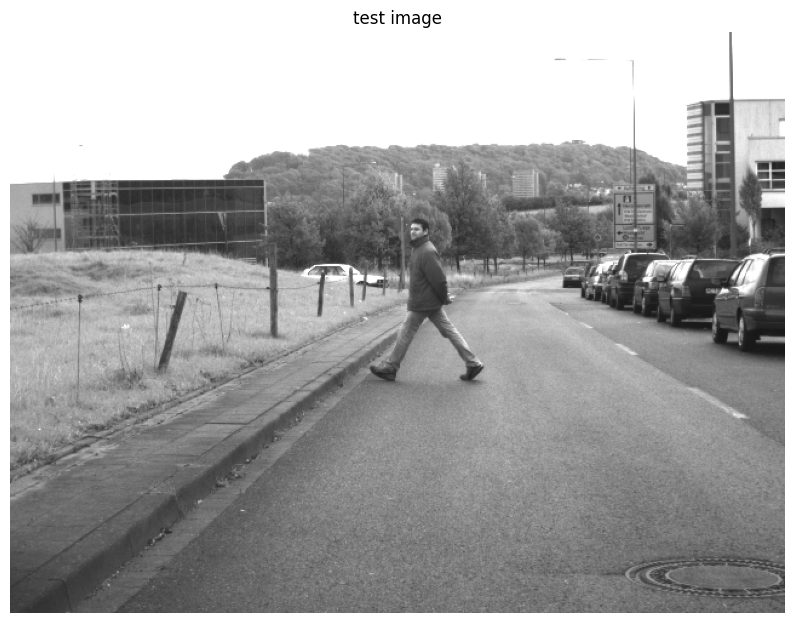

In [12]:
# load one image
%matplotlib inline
image = load(filenamesList[50])
show_image(image, 'test image')

I use Tensorflow with GPU and in wsl2 there are problems with linking to libcuda.so as Nvidia installs it without symlinks.

Fix:
```
cd /usr/lib/wsl/lib
sudo rm libcuda.so libcuda.so.1
sudo ln -s libcuda.so.1.1 libcuda.so.1
sudo ln -s libcuda.so.1 libcuda.so
sudo ldconfig

<!-- maybe also export lib path -->
export LD_LIBRARY_PATH=/usr/lib/wsl/lib:$LD_LIBRARY_PATH
```

In [13]:
# test if the detector works
tr_image = image_tensor(image,SIZE,SIZE)
print(tr_image.shape)

detector_output = detector(tr_image)

(1, 320, 320, 3)


2024-01-16 12:56:49.033953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-16 12:56:49.398869: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [32]:
# Print the Scores, Classes and Bounding Boxes for the detections.
num_dets = (detector_output['num_detections'][0].numpy()).astype(int)
print(num_dets)
 
print('\nDetection Scores: \n\n', detector_output['detection_scores'][0].numpy()[0:num_dets])
print('\nDetection Classes: \n\n', detector_output['detection_classes'].numpy()[0][0:num_dets])
print('\nDetection Boxes: \n\n', detector_output['detection_boxes'][0].numpy()[0:num_dets])

100

Detection Scores: 

 [0.7515145  0.71375287 0.6666401  0.62580967 0.565804   0.4785761
 0.4505931  0.4049104  0.3962452  0.38565505 0.35393703 0.34102544
 0.32386237 0.31348848 0.30989683 0.30886006 0.3062705  0.280463
 0.27104986 0.2691063  0.26108634 0.2554802  0.24759975 0.24597533
 0.24528146 0.24512832 0.24069647 0.23597497 0.23497294 0.23385388
 0.23211586 0.22900197 0.22289996 0.22157875 0.22119817 0.21953781
 0.21784283 0.21191016 0.20828103 0.2066237  0.20597425 0.20339352
 0.199934   0.1992563  0.18962815 0.18636201 0.18427566 0.18228053
 0.1821373  0.17970885 0.17755914 0.17403296 0.17319703 0.17015375
 0.16962317 0.16902545 0.16868047 0.16825216 0.16362715 0.1581771
 0.154455   0.15380433 0.15368608 0.1532281  0.15322421 0.15300608
 0.15074952 0.15028372 0.1489456  0.14825961 0.14657764 0.14655113
 0.14638406 0.1448463  0.14283966 0.14078757 0.1402098  0.1400328
 0.13995303 0.13943459 0.13900548 0.13872159 0.13857724 0.13847104
 0.13739367 0.13721131 0.1370481  0.13677

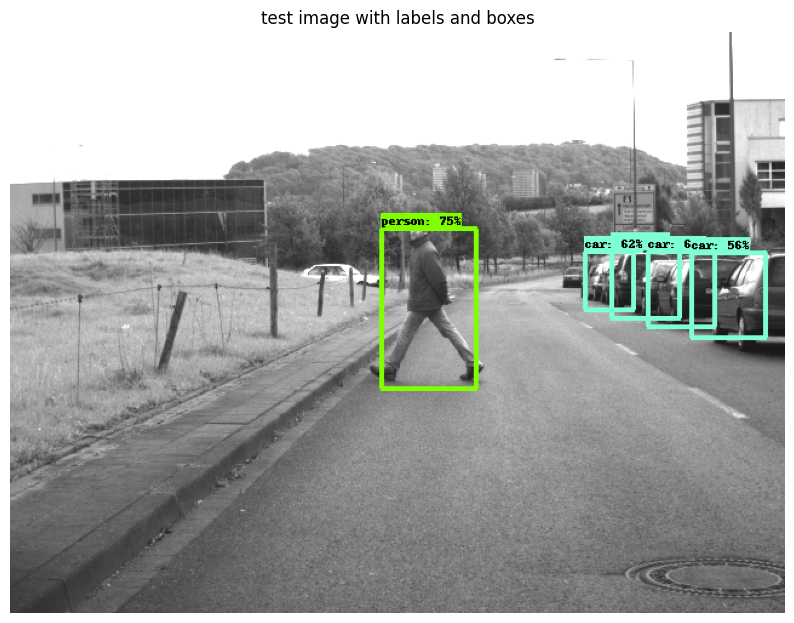

In [14]:
# test visualization with deteced boxes and labels
%matplotlib inline
vis_image = visualize(image,detector_output,LABELS)
show_image(vis_image, 'test image with labels and boxes')

Now I can make a detection pipeline.

In [15]:
# detection pipeline

def detect(fileList, cur_nn, cv_show=False):
    detectedImages = []
    SIZE = nn_models[cur_nn]['size']
    LABELS = nn_models[cur_nn]['labels']
    
    for im in fileList:
        cur_image = load(im)
        cur_tr_image = image_tensor(cur_image,SIZE,SIZE)

        cur_detector_output = detector(cur_tr_image)

        cur_vis_image = visualize(cur_image,cur_detector_output,LABELS)
        
        # show the output images
        h,w,ch = cur_vis_image.shape 
        detectedImages.append(cur_vis_image.astype("uint8"))

        # to show
        if cv_show:
            res_image = cv2.resize(cur_vis_image.astype('float32'), (w*2,h*2,))
            cv2.imshow("detected", res_image.astype("uint8"))
            cv2.waitKey(10)

    cv2.destroyAllWindows()
    return detectedImages

And detect all images I want.

In [16]:
# detect images with current neural network model
detected_images = detect(filenamesList, CURRENT_MODEL, cv_show=True)

Optional import to gif.

In [17]:
import imageio
gif_name = os.path.dirname(os.getcwd()) + "/object_detection/detected/one.gif"
imageio.mimsave(gif_name, detected_images)

And finally I can also plot some of the detected images. 

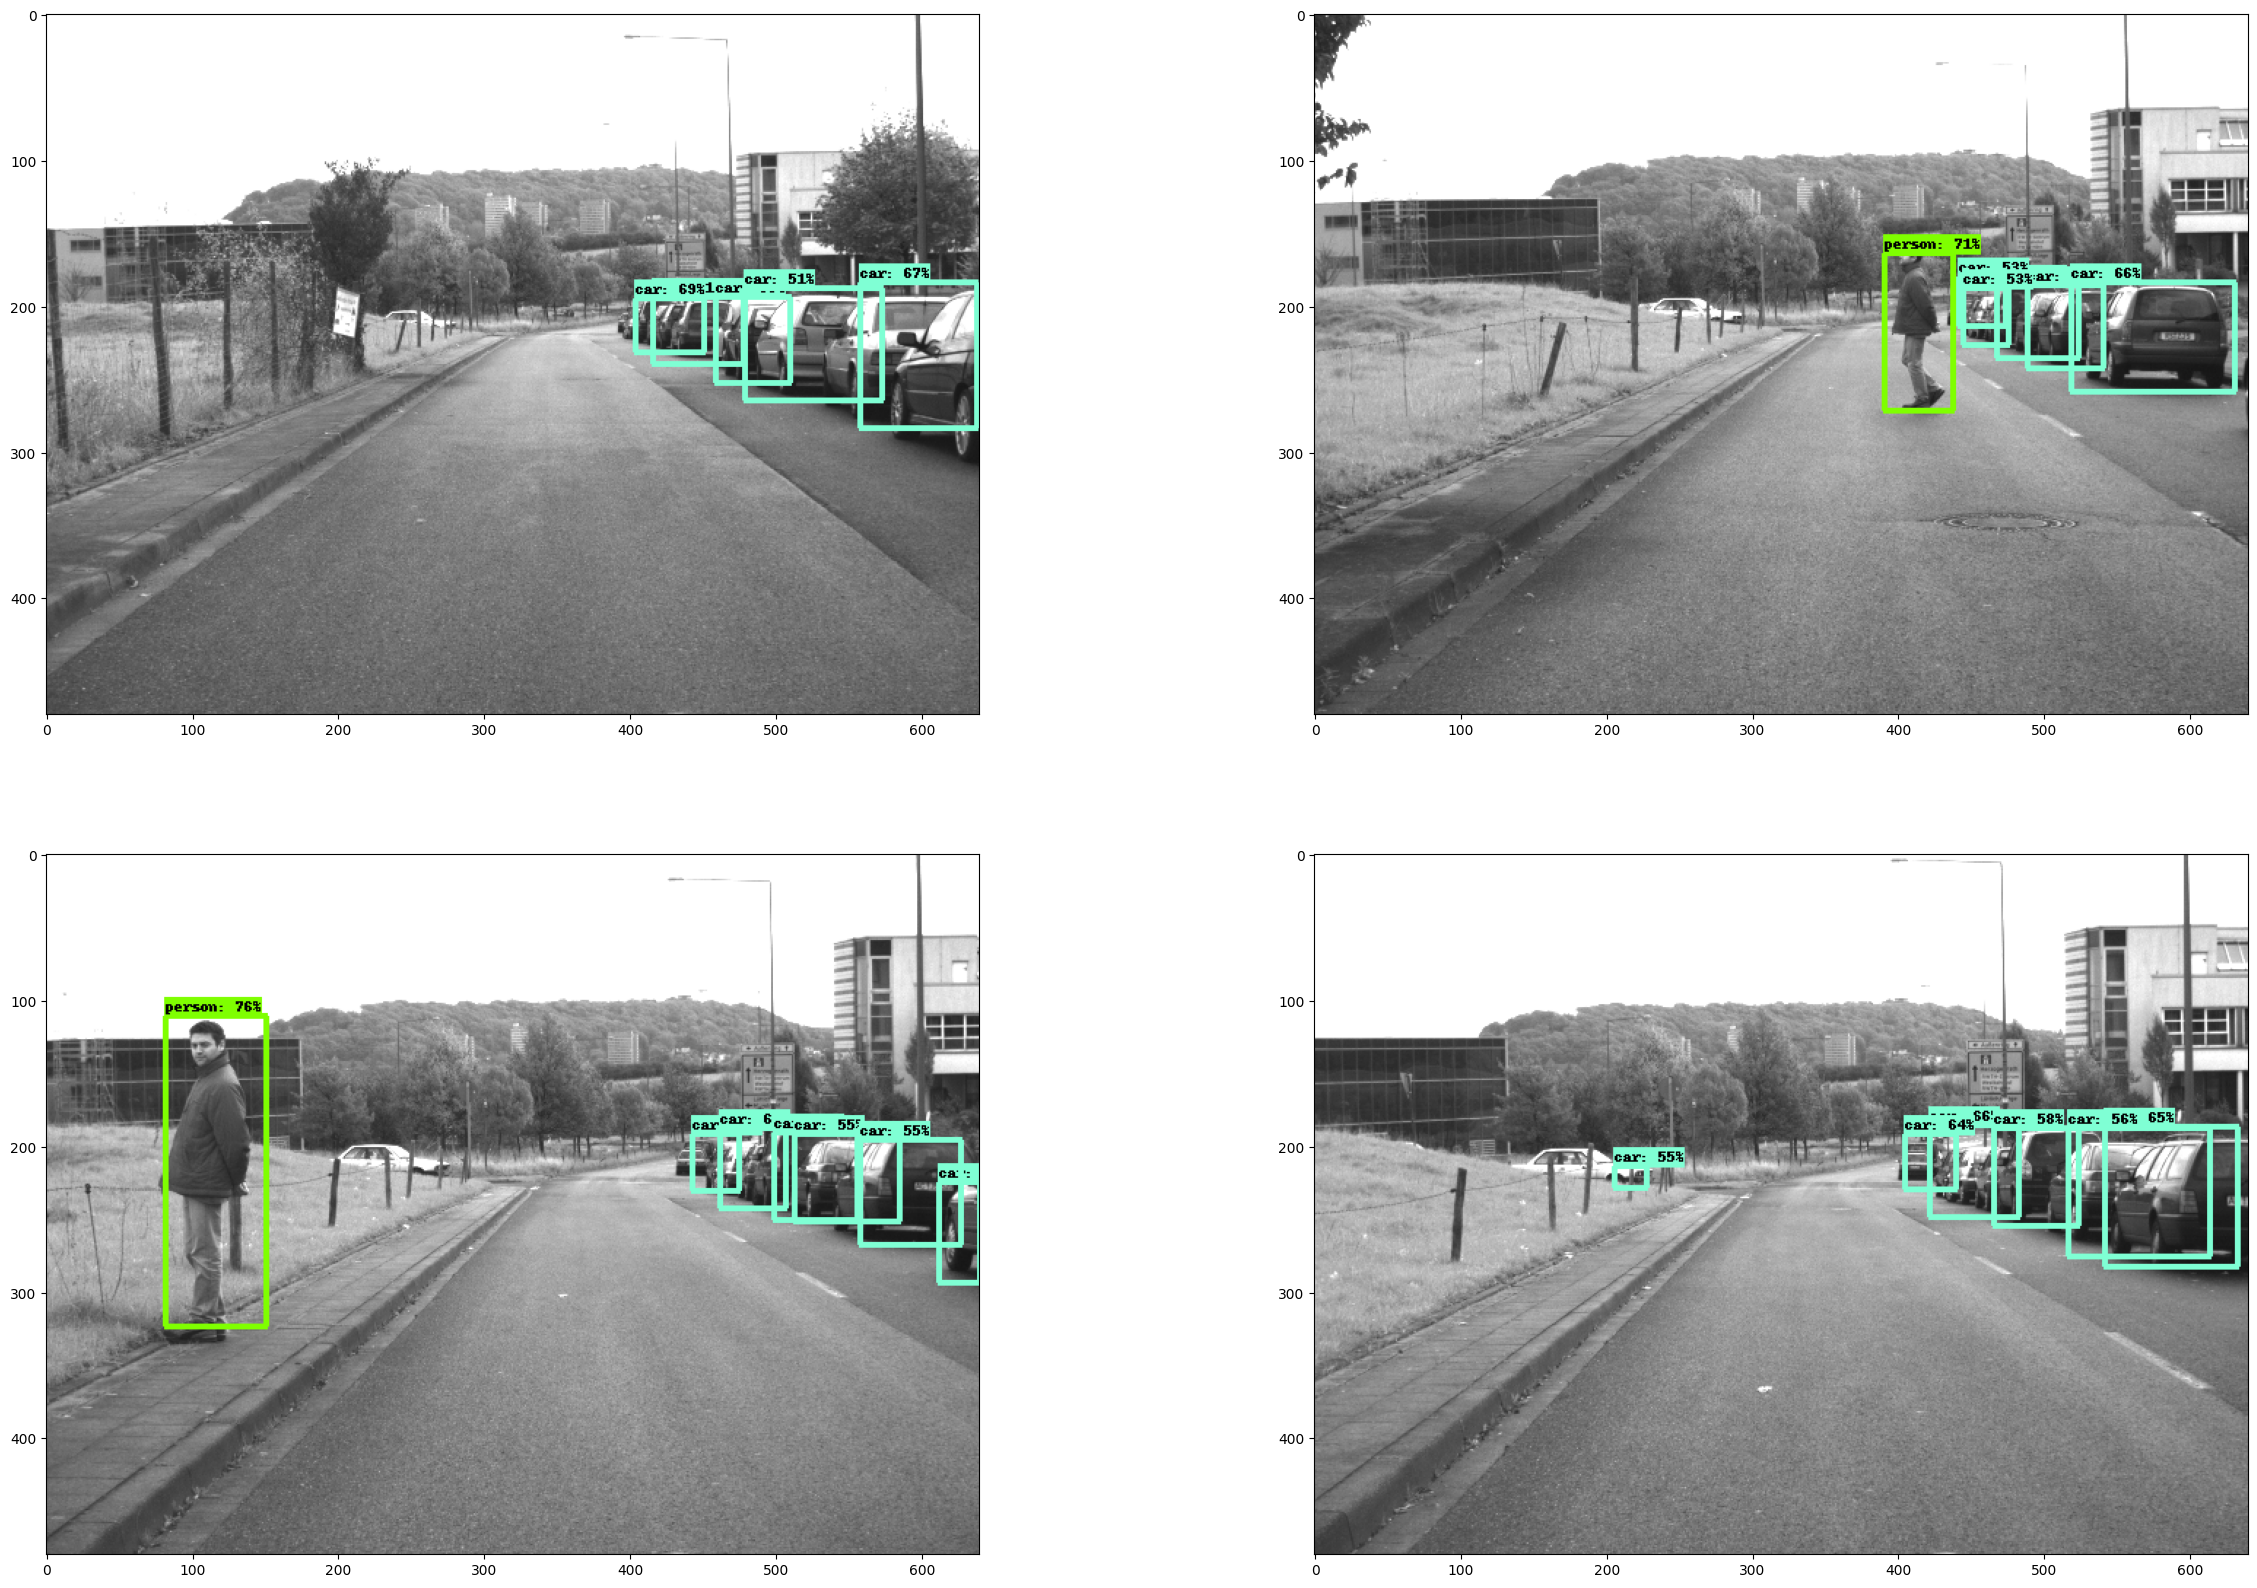

In [20]:
images_for_plot = []
images_for_plot.append(detected_images[20])
images_for_plot.append(detected_images[40])
images_for_plot.append(detected_images[60])
images_for_plot.append(detected_images[75])
plot_images(images_for_plot, 2, (30,20))

Lets try `efficientdet` neural network. EfficientDet-Lite0 version has feature vector and can be tuned.

In [22]:
CURRENT_MODEL = 'efficientdet'
SIZE = nn_models[CURRENT_MODEL]['size']
URL = nn_models[CURRENT_MODEL]['url']
LABELS = nn_models[CURRENT_MODEL]['labels']

# no need to make it a keras layer
detector = hub.load(URL)

In [23]:
efficientdet_detected_images = detect(filenamesList, CURRENT_MODEL, cv_show=True)

Here I compare images by both detectors.

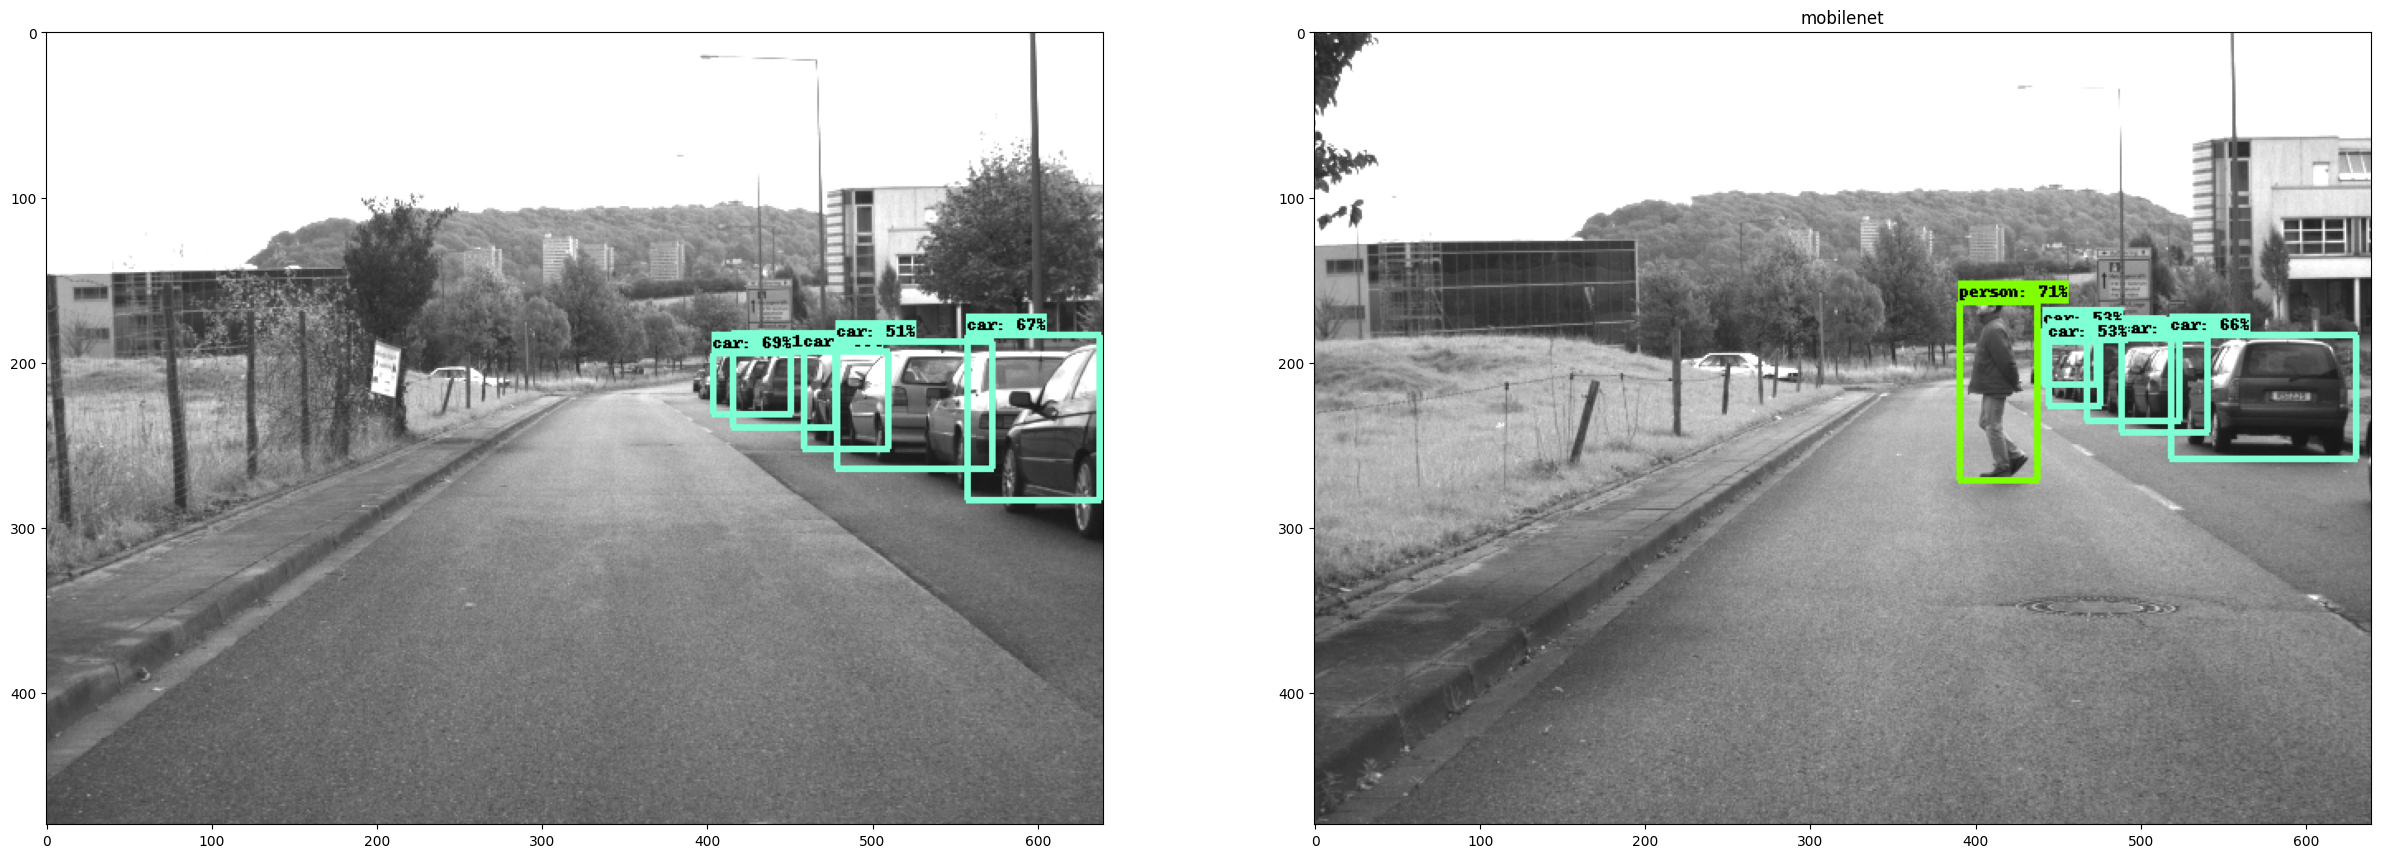

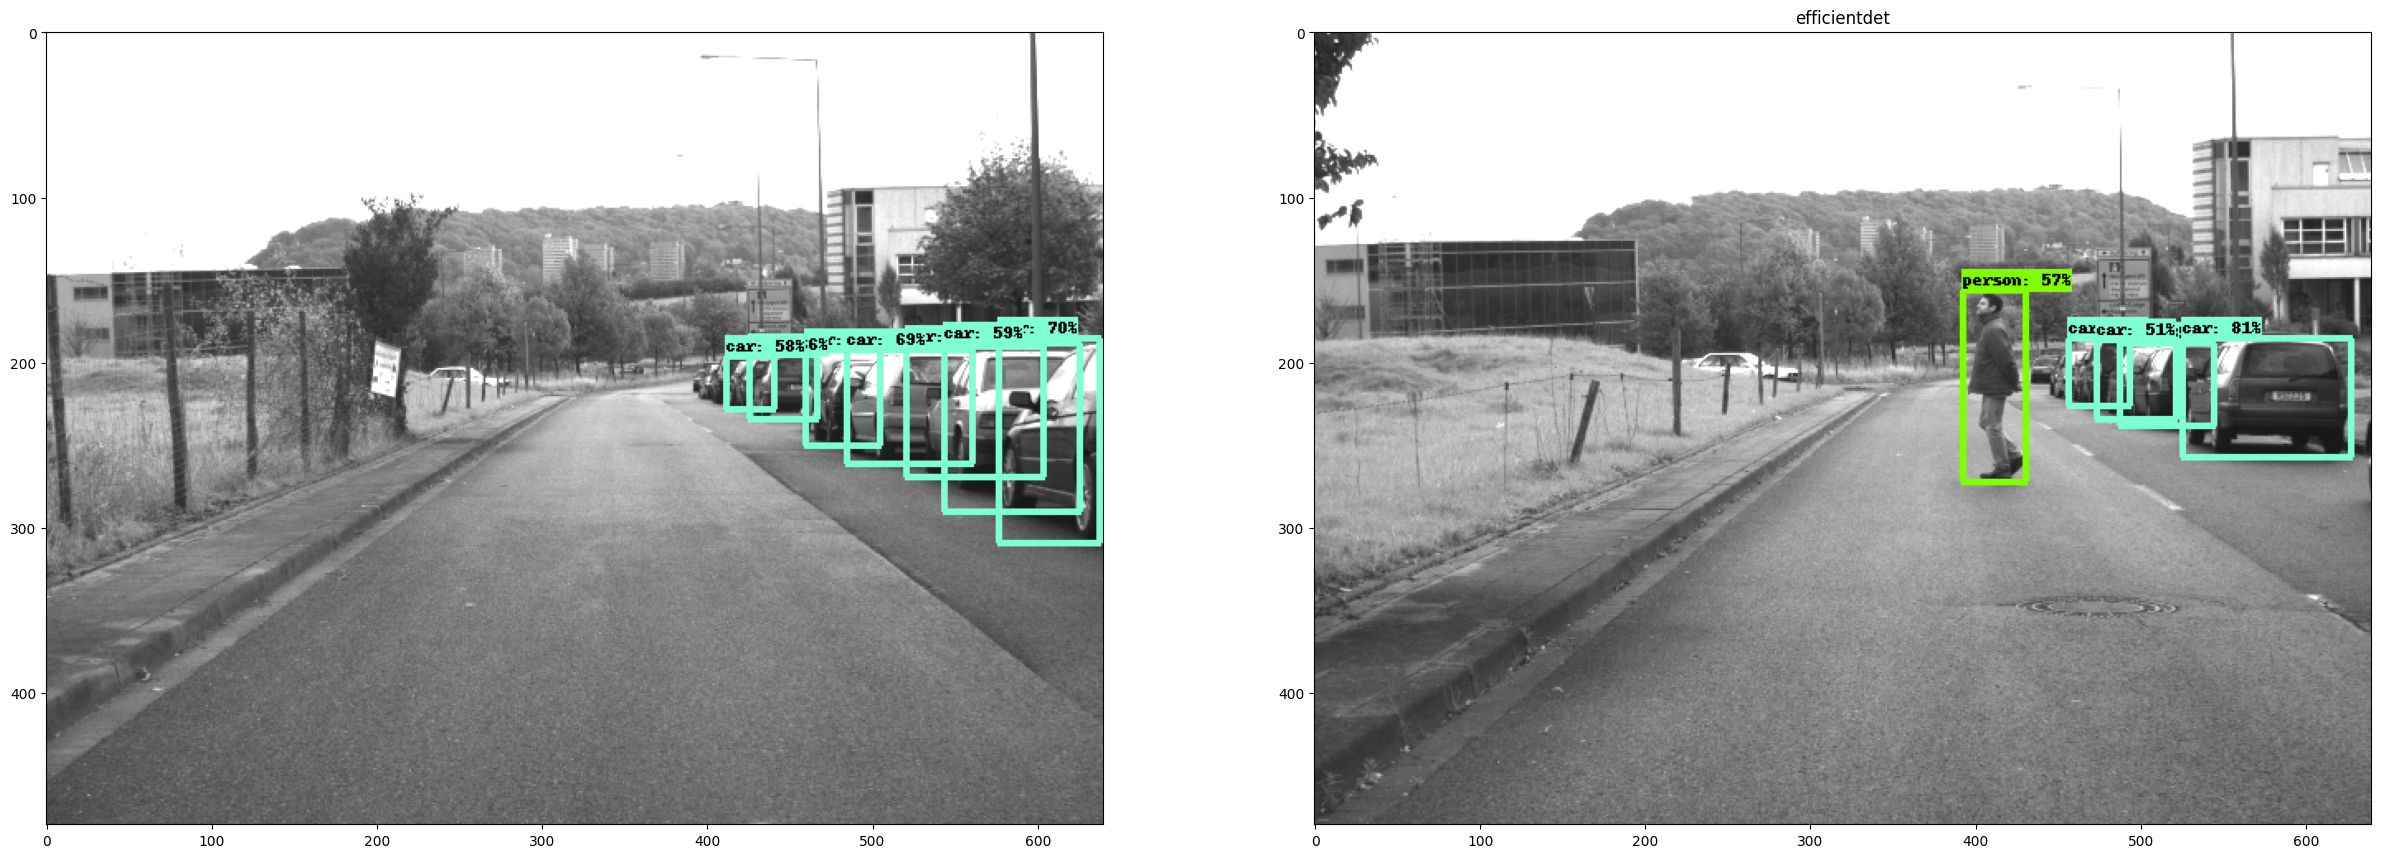

In [29]:
images_for_plot = []
images_for_plot.append(detected_images[20])
images_for_plot.append(detected_images[40])
images_for_plot.append(efficientdet_detected_images[20])
images_for_plot.append(efficientdet_detected_images[40])
# images_for_plot.append(detected_images[60])
# images_for_plot.append(efficientdet_detected_images[60])
# images_for_plot.append(detected_images[75])
# images_for_plot.append(efficientdet_detected_images[75])

plot_images(images_for_plot[:2], 2, (30,20), "mobilenet")
plot_images(images_for_plot[2:], 2, (30,20), "efficientdet")